In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

TARGET = "Critical Cooling Rate"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
FEATURES = {
    "PI": ['size_diff', 'size_ratio', 'size_range', 'DeltaH', 'CrystalMismatch0', 'Tmean', 'CrystalMismatch1'],
    "EP": ['Composition', 'CompositionA',
        'Atomic Number', 'Mendeleev Number', 'Atomic Weight',
        'Melting Temperature (K)', 'Column', 'Row', 'Covalent Radius',
        'Electronegativity', '# s Valence Electrons', '# p Valence Electrons',
        '# d Valence Electrons', '# f Valence Electrons',
        'Total # Valence Electrons', '# Unfilled s States',
        '# Unfilled p States', '# Unfilled d States', '# Unfilled f States',
        'Total # Unfilled States', 'Specific Volume of 0K Ground State',
        'Band Gap Energy of 0K Ground State',
        'Magnetic Moment of 0K Gound State', 'Space Goup # of 0K Ground State',
        'Radius by Miracle (Atomic size)', 'Boiling Temperature', 'Density',
        '1st Ioniztion Energy', 'Mass Heat Capacity', 'Molar Heat Capacity',
        'Heat of Fusion', 'Phi', 'n_ws 3rd', 'Cohesive E', 'Atomic NumberB',
        'Mendeleev NumberB', 'Atomic WeightB', 'Melting Temperature (K)B',
        'ColumnB', 'RowB', 'Covalent RadiusB', 'ElectronegativityB',
        '# s Valence ElectronsB', '# p Valence ElectronsB',
        '# d Valence ElectronsB', '# f Valence ElectronsB',
        'Total # Valence ElectronsB', '# Unfilled s StatesB',
        '# Unfilled p StatesB', '# Unfilled d StatesB', '# Unfilled f StatesB',
        'Total # Unfilled StatesB', 'Specific Volume of 0K Ground StateB',
        'Band Gap Energy of 0K Ground StateB',
        'Magnetic Moment of 0K Gound StateB',
        'Space Goup # of 0K Ground StateB', 'Radius by Miracle (Atomic size)B',
        'Boiling TemperatureB', 'DensityB', '1st Ioniztion EnergyB',
        'Mass Heat CapacityB', 'Molar Heat CapacityB', 'Heat of FusionB',
        'PhiB', 'n_ws 3rdB', 'Cohesive EB'],
    "Comp": ['W', 'Ni', 'Fe', 'Mg', 'Pd', 'Al', 'Ta', 'Sn', 'Cu', 'Hf', 'Nb', 'Ag','Pt', 'Ti', 'Mo', 
            'V', 'Zr', 'Mn', 'Au', 'Co', 'Si', 'Y', 'Cr', 'Ge'],
    "Random": ['col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'col7']
}

In [3]:
def prepare_dataset(df: pd.DataFrame, dataset_name: str, device=None):
    selected = FEATURES[dataset_name]
    X = torch.tensor(df[selected].values, dtype=torch.float32)
    y = torch.tensor(df[TARGET].values, dtype=torch.float32)
    if device is not None:
        X = X.to(device)
        y = y.to(device)
    
    return X, y

In [4]:
df_pi   = pd.read_csv("rc_PI_binary_new.csv")
df_ep   = pd.read_csv("rc_EP_binary.csv")
df_comp = pd.read_csv("rc_Comp_binary.csv")
df_rand = pd.read_csv("rc_Random_binary.csv")

In [5]:
class NN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

In [6]:
class BetterNN(nn.Module):
    def __init__(self, input_dim, widths=(128, 64, 32), p=0.15):
        super().__init__()
        layers = []
        prev = input_dim
        for w in widths:
            layers += [nn.Linear(prev, w), nn.BatchNorm1d(w), nn.LeakyReLU(), nn.Dropout(p)]
            prev = w
        layers += [nn.Linear(prev, 1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [18]:
import copy

class EarlyStopper:
    def __init__(self, patience=12, min_delta=0.0):
        self.patience   = patience
        self.min_delta  = min_delta
        self.best_value = float('inf')
        self.wait       = 0
        self.best_state = None

    def step(self, val_metric, model):
        # lower is better
        if val_metric + self.min_delta < self.best_value:
            self.best_value = val_metric
            self.wait = 0
            self.best_state = copy.deepcopy(model.state_dict())
            return False  # don't stop
        else:
            self.wait += 1
            return self.wait >= self.patience


In [19]:
def plot_pred_vs_actual(per_system_results, n=6, rng_seed=0):
    rng = np.random.default_rng(rng_seed)
    choices = rng.choice(len(per_system_results), size=min(n, len(per_system_results)), replace=False)
    figs = []
    for idx in choices:
        system, y_true, y_pred = per_system_results[idx]
        plt.figure()
        plt.scatter(y_true, y_pred, s=10)
        m = max(np.max(y_true), np.max(y_pred))
        plt.plot([0, m], [0, m], lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.title(system)
        plt.show()

def plot_error_hist(per_system_results):
    errors = np.concatenate([pred - true for _, true, pred in per_system_results])
    plt.figure()
    plt.hist(errors, bins=50)
    plt.xlabel("Prediction - Actual"); plt.ylabel("Count"); plt.title("Error Histogram")
    plt.show()

In [20]:
def run_loop(df: pd.DataFrame, feature: str, epochs: int = 50, batch_size: int = 1024, lr: float = 1e-3, device=None):
    assert device is not None, "Pass a torch.device, e.g., torch.device('cuda')"
    systems = df["Alloy System"].unique()
    mapes, res = [], []

    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    for system_left_out in systems:
        train = df[df["Alloy System"] != system_left_out]
        test  = df[df["Alloy System"] == system_left_out]

        # ---- Tensors on device ----
        X_train, y_train = prepare_dataset(train, feature, device=device)
        X_test,  y_test  = prepare_dataset(test,  feature, device=device)

        # ---- Standardize on GPU (train-only stats) ----
        mean = X_train.mean(dim=0, keepdim=True)
        std  = X_train.std(dim=0, unbiased=False, keepdim=True).clamp_min(1e-8)
        X_train = (X_train - mean) / std
        X_test  = (X_test  - mean) / std

        # ---- Build a small validation split from training (on GPU) ----
        N = X_train.size(0)
        val_frac = 0.1
        val_n = max(1, int(N * val_frac))
        perm_tv = torch.randperm(N, device=device)
        val_idx = perm_tv[:val_n]
        trn_idx = perm_tv[val_n:]

        X_tr, y_tr = X_train[trn_idx], y_train[trn_idx]
        X_val, y_val = X_train[val_idx], y_train[val_idx]

        # ---- Model / Opt ----
        model = BetterNN(X_train.shape[1]).to(device)
        val_criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

        # optional LR plateau scheduler (plays nicely with early stopping)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )

        bs = min(batch_size, X_tr.size(0))
        stopper = EarlyStopper(patience=12, min_delta=0.0)

        # ---- Train with early stopping ----
        for epoch in range(epochs):  # 'epochs' is just a cap now
            model.train()
            perm = torch.randperm(X_tr.size(0), device=device)
            epoch_loss = 0.0

            for i in range(0, X_tr.size(0), bs):
                idx = perm[i:i+bs]
                xb = X_tr[idx]
                yb = y_tr[idx].view(-1, 1)

                optimizer.zero_grad(set_to_none=True)
                pred = model(xb)
                loss = val_criterion(pred, yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.detach().item() * xb.size(0)

            tr_loss = epoch_loss / X_tr.size(0)
            # ---- Validation on GPU ----
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val).squeeze(1)
                val_loss = val_criterion(val_pred, y_val).item()
                # optional: val MAPE (nice to log)
                eps = 1e-8
                val_mape = float(((val_pred - y_val).abs() / y_val.abs().clamp_min(eps)).mean().item())
            scheduler.step(val_loss)

            if (epoch + 1) % 10 == 0:
                print(f"[{feature}] {system_left_out} | Epoch {epoch+1}/{epochs} "
                      f"train {tr_loss:.4f} | val {val_loss:.4f} (MAPE {val_mape:.3f}) "
                      f"| lr {optimizer.param_groups[0]['lr']:.2e}")

            # ---- Early stopping check (keeps best weights internally) ----
            if stopper.step(val_loss, model):
                print(f"[{feature}] {system_left_out} | Early stop at epoch {epoch+1} "
                      f"(best val {stopper.best_value:.4f})")
                break

        # ---- Restore best weights before test ----
        if stopper.best_state is not None:
            model.load_state_dict(stopper.best_state)

        # ---- Evaluate on test ----
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test).squeeze(1)
        eps = 1e-8
        mape = float(((y_pred - y_test).abs() / y_test.abs().clamp_min(eps)).mean().item())
        mapes.append(mape)

        # ---- Save/plot (CPU only for plotting) ----
        y_test_cpu = y_test.detach().cpu().numpy()
        y_pred_cpu = y_pred.detach().cpu().numpy()
        res.append((system_left_out, y_test_cpu, y_pred_cpu))

        plt.figure(figsize=(5,5))
        plt.scatter(y_test_cpu, y_pred_cpu, s=10, alpha=0.7)
        m = max(y_test_cpu.max(), y_pred_cpu.max())
        plt.plot([0, m], [0, m], 'r--', lw=1)
        plt.xlabel("Actual"); plt.ylabel("Predicted")
        plt.title(f"{feature} | {system_left_out} (MAPE {mape:.2f})")
        plt.show()

        print(f"[{feature}] Left-out: {system_left_out} | Test MAPE: {mape:.4f}")

    return float(np.mean(mapes)), mapes, res


[PI] AlNi | Epoch 10/200 train 42.8647 | val 38.5667 (MAPE 0.602) | lr 1.00e-03
[PI] AlNi | Epoch 20/200 train 5.3857 | val 3.9893 (MAPE 0.188) | lr 1.00e-03
[PI] AlNi | Epoch 30/200 train 3.0712 | val 1.5227 (MAPE 0.113) | lr 1.00e-03
[PI] AlNi | Epoch 40/200 train 2.7501 | val 1.3476 (MAPE 0.104) | lr 1.00e-03
[PI] AlNi | Epoch 50/200 train 2.5891 | val 1.0158 (MAPE 0.095) | lr 1.00e-03
[PI] AlNi | Epoch 60/200 train 2.3313 | val 0.9495 (MAPE 0.085) | lr 1.00e-03
[PI] AlNi | Epoch 70/200 train 2.2359 | val 0.7779 (MAPE 0.081) | lr 1.00e-03
[PI] AlNi | Epoch 80/200 train 2.1687 | val 0.8043 (MAPE 0.075) | lr 1.00e-03
[PI] AlNi | Epoch 90/200 train 2.1723 | val 0.6200 (MAPE 0.067) | lr 1.00e-03
[PI] AlNi | Epoch 100/200 train 1.9388 | val 0.5585 (MAPE 0.064) | lr 1.00e-03
[PI] AlNi | Epoch 110/200 train 1.9403 | val 0.5413 (MAPE 0.060) | lr 1.00e-03
[PI] AlNi | Epoch 120/200 train 1.8001 | val 0.5034 (MAPE 0.056) | lr 5.00e-04
[PI] AlNi | Epoch 130/200 train 1.7565 | val 0.4600 (MAPE 0

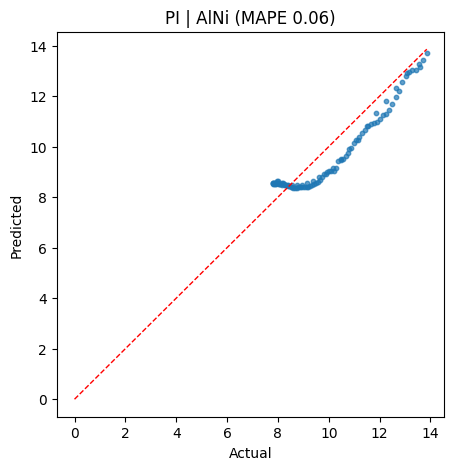

[PI] Left-out: AlNi | Test MAPE: 0.0633
[PI] CuMg | Epoch 10/200 train 35.0947 | val 29.8277 (MAPE 0.523) | lr 1.00e-03
[PI] CuMg | Epoch 20/200 train 4.5732 | val 3.1170 (MAPE 0.163) | lr 1.00e-03
[PI] CuMg | Epoch 30/200 train 2.9192 | val 1.2737 (MAPE 0.112) | lr 1.00e-03
[PI] CuMg | Epoch 40/200 train 2.5499 | val 0.9760 (MAPE 0.091) | lr 1.00e-03
[PI] CuMg | Epoch 50/200 train 2.2141 | val 0.7881 (MAPE 0.082) | lr 1.00e-03
[PI] CuMg | Epoch 60/200 train 2.1597 | val 0.6791 (MAPE 0.072) | lr 1.00e-03
[PI] CuMg | Epoch 70/200 train 2.0169 | val 0.5898 (MAPE 0.065) | lr 1.00e-03
[PI] CuMg | Epoch 80/200 train 1.9736 | val 0.5722 (MAPE 0.062) | lr 1.00e-03
[PI] CuMg | Epoch 90/200 train 1.9122 | val 0.4586 (MAPE 0.056) | lr 5.00e-04
[PI] CuMg | Early stop at epoch 97 (best val 0.4506)


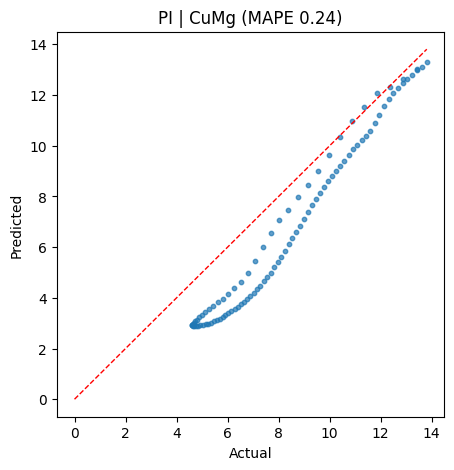

[PI] Left-out: CuMg | Test MAPE: 0.2381
[PI] NiMg | Epoch 10/200 train 41.4734 | val 36.4209 (MAPE 0.582) | lr 1.00e-03
[PI] NiMg | Epoch 20/200 train 5.5897 | val 3.8690 (MAPE 0.181) | lr 1.00e-03
[PI] NiMg | Epoch 30/200 train 2.9246 | val 1.4801 (MAPE 0.112) | lr 1.00e-03
[PI] NiMg | Epoch 40/200 train 2.6673 | val 1.1970 (MAPE 0.095) | lr 1.00e-03
[PI] NiMg | Epoch 50/200 train 2.2719 | val 0.9643 (MAPE 0.084) | lr 1.00e-03
[PI] NiMg | Epoch 60/200 train 2.1920 | val 0.8910 (MAPE 0.080) | lr 5.00e-04
[PI] NiMg | Epoch 70/200 train 2.0611 | val 0.8528 (MAPE 0.075) | lr 5.00e-04
[PI] NiMg | Epoch 80/200 train 2.1384 | val 0.8165 (MAPE 0.074) | lr 5.00e-04
[PI] NiMg | Epoch 90/200 train 2.0907 | val 0.7643 (MAPE 0.069) | lr 2.50e-04
[PI] NiMg | Epoch 100/200 train 1.9672 | val 0.7563 (MAPE 0.069) | lr 1.25e-04
[PI] NiMg | Epoch 110/200 train 2.0617 | val 0.7426 (MAPE 0.068) | lr 1.25e-04
[PI] NiMg | Epoch 120/200 train 1.9969 | val 0.7492 (MAPE 0.069) | lr 6.25e-05
[PI] NiMg | Epoch 1

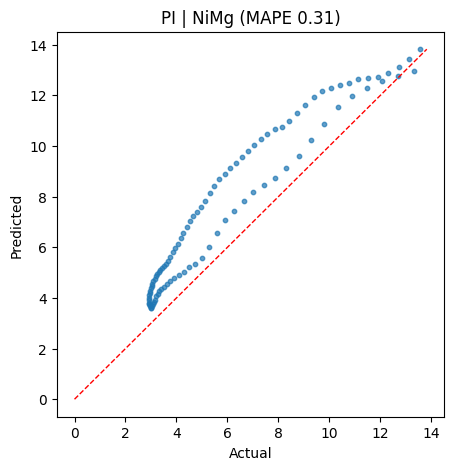

[PI] Left-out: NiMg | Test MAPE: 0.3076
[PI] AlTi | Epoch 10/200 train 34.1801 | val 32.0853 (MAPE 0.541) | lr 1.00e-03
[PI] AlTi | Epoch 20/200 train 4.4886 | val 3.3858 (MAPE 0.174) | lr 1.00e-03
[PI] AlTi | Epoch 30/200 train 2.9841 | val 1.6910 (MAPE 0.123) | lr 1.00e-03
[PI] AlTi | Epoch 40/200 train 2.7608 | val 1.3357 (MAPE 0.104) | lr 1.00e-03
[PI] AlTi | Epoch 50/200 train 2.4442 | val 1.0924 (MAPE 0.094) | lr 1.00e-03
[PI] AlTi | Epoch 60/200 train 2.2952 | val 0.9205 (MAPE 0.085) | lr 1.00e-03
[PI] AlTi | Epoch 70/200 train 2.1195 | val 0.8044 (MAPE 0.078) | lr 1.00e-03
[PI] AlTi | Epoch 80/200 train 2.0898 | val 0.7280 (MAPE 0.074) | lr 1.00e-03
[PI] AlTi | Epoch 90/200 train 2.0027 | val 0.7148 (MAPE 0.072) | lr 1.00e-03
[PI] AlTi | Epoch 100/200 train 1.8638 | val 0.6294 (MAPE 0.066) | lr 5.00e-04
[PI] AlTi | Epoch 110/200 train 1.8290 | val 0.5923 (MAPE 0.064) | lr 5.00e-04
[PI] AlTi | Epoch 120/200 train 1.8691 | val 0.5695 (MAPE 0.060) | lr 2.50e-04
[PI] AlTi | Epoch 1

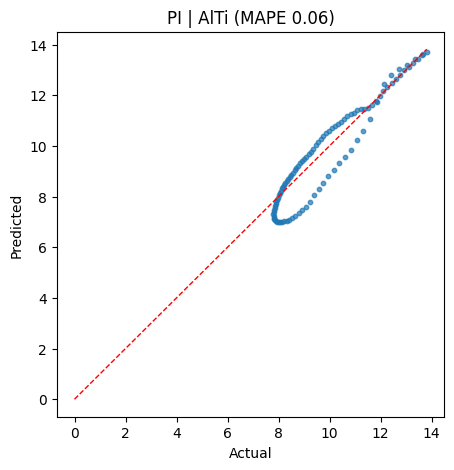

[PI] Left-out: AlTi | Test MAPE: 0.0571
[PI] AlV | Epoch 10/200 train 47.7782 | val 45.4346 (MAPE 0.638) | lr 1.00e-03
[PI] AlV | Epoch 20/200 train 6.5044 | val 5.4193 (MAPE 0.208) | lr 1.00e-03
[PI] AlV | Epoch 30/200 train 3.2238 | val 1.4407 (MAPE 0.104) | lr 1.00e-03
[PI] AlV | Epoch 40/200 train 2.8466 | val 1.0779 (MAPE 0.091) | lr 1.00e-03
[PI] AlV | Epoch 50/200 train 2.6568 | val 0.8267 (MAPE 0.077) | lr 1.00e-03
[PI] AlV | Epoch 60/200 train 2.3849 | val 0.7825 (MAPE 0.077) | lr 1.00e-03
[PI] AlV | Epoch 70/200 train 2.3894 | val 0.7187 (MAPE 0.067) | lr 1.00e-03
[PI] AlV | Epoch 80/200 train 2.3213 | val 0.6171 (MAPE 0.064) | lr 5.00e-04
[PI] AlV | Epoch 90/200 train 2.1398 | val 0.5876 (MAPE 0.061) | lr 2.50e-04
[PI] AlV | Epoch 100/200 train 2.0813 | val 0.5414 (MAPE 0.060) | lr 2.50e-04
[PI] AlV | Epoch 110/200 train 2.0656 | val 0.5253 (MAPE 0.057) | lr 1.25e-04
[PI] AlV | Early stop at epoch 118 (best val 0.5047)


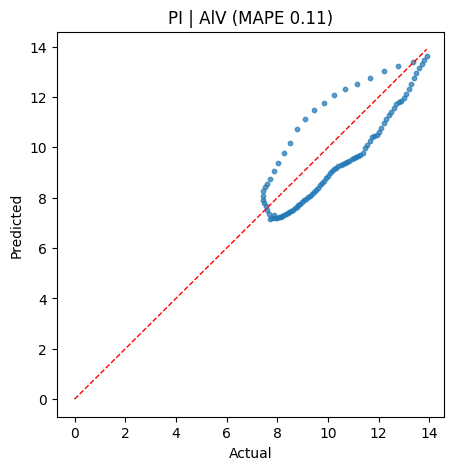

[PI] Left-out: AlV | Test MAPE: 0.1086
[PI] VNi | Epoch 10/200 train 48.6911 | val 45.1478 (MAPE 0.637) | lr 1.00e-03
[PI] VNi | Epoch 20/200 train 7.2595 | val 5.3067 (MAPE 0.210) | lr 1.00e-03
[PI] VNi | Epoch 30/200 train 3.2905 | val 1.6787 (MAPE 0.116) | lr 1.00e-03
[PI] VNi | Epoch 40/200 train 2.7171 | val 1.2234 (MAPE 0.101) | lr 1.00e-03
[PI] VNi | Epoch 50/200 train 2.4771 | val 0.9858 (MAPE 0.091) | lr 1.00e-03
[PI] VNi | Epoch 60/200 train 2.1844 | val 0.8103 (MAPE 0.074) | lr 1.00e-03
[PI] VNi | Epoch 70/200 train 2.2046 | val 0.7526 (MAPE 0.075) | lr 1.00e-03
[PI] VNi | Epoch 80/200 train 2.0489 | val 0.7364 (MAPE 0.075) | lr 1.00e-03
[PI] VNi | Epoch 90/200 train 1.9878 | val 0.6197 (MAPE 0.063) | lr 1.00e-03
[PI] VNi | Epoch 100/200 train 1.8875 | val 0.5524 (MAPE 0.061) | lr 1.00e-03
[PI] VNi | Epoch 110/200 train 1.8050 | val 0.5131 (MAPE 0.055) | lr 5.00e-04
[PI] VNi | Epoch 120/200 train 1.7445 | val 0.4842 (MAPE 0.055) | lr 5.00e-04
[PI] VNi | Epoch 130/200 train 1

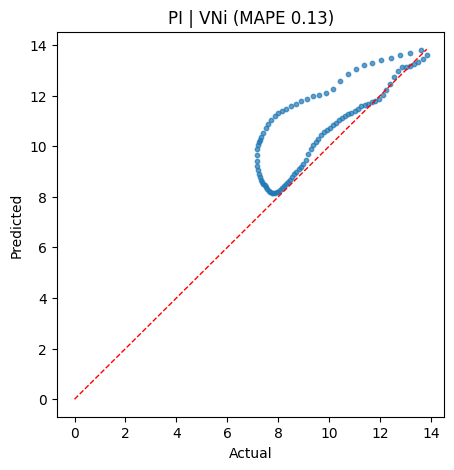

[PI] Left-out: VNi | Test MAPE: 0.1348
[PI] CuSi | Epoch 10/200 train 49.0504 | val 45.6130 (MAPE 0.648) | lr 1.00e-03
[PI] CuSi | Epoch 20/200 train 6.9418 | val 5.2738 (MAPE 0.206) | lr 1.00e-03
[PI] CuSi | Epoch 30/200 train 2.8637 | val 1.2758 (MAPE 0.106) | lr 1.00e-03
[PI] CuSi | Epoch 40/200 train 2.6663 | val 0.9684 (MAPE 0.089) | lr 1.00e-03
[PI] CuSi | Epoch 50/200 train 2.4185 | val 0.7503 (MAPE 0.075) | lr 1.00e-03
[PI] CuSi | Epoch 60/200 train 2.1582 | val 0.5746 (MAPE 0.063) | lr 1.00e-03
[PI] CuSi | Epoch 70/200 train 2.2036 | val 0.5021 (MAPE 0.059) | lr 1.00e-03
[PI] CuSi | Epoch 80/200 train 2.0641 | val 0.4510 (MAPE 0.055) | lr 1.00e-03
[PI] CuSi | Epoch 90/200 train 1.8859 | val 0.4244 (MAPE 0.052) | lr 1.00e-03
[PI] CuSi | Epoch 100/200 train 1.8238 | val 0.3619 (MAPE 0.047) | lr 5.00e-04
[PI] CuSi | Epoch 110/200 train 1.7839 | val 0.3510 (MAPE 0.045) | lr 2.50e-04
[PI] CuSi | Epoch 120/200 train 1.7990 | val 0.3135 (MAPE 0.042) | lr 2.50e-04
[PI] CuSi | Epoch 13

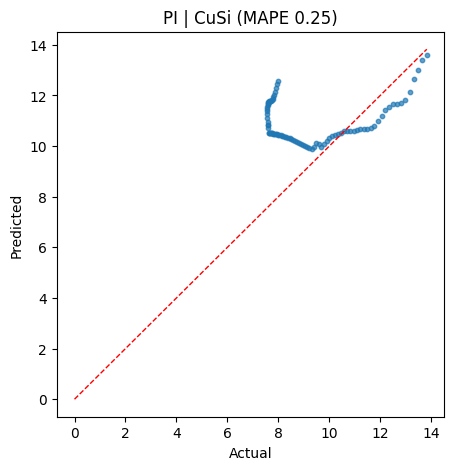

[PI] Left-out: CuSi | Test MAPE: 0.2513
[PI] VSi | Epoch 10/200 train 41.5837 | val 37.3148 (MAPE 0.581) | lr 1.00e-03
[PI] VSi | Epoch 20/200 train 5.4557 | val 3.8758 (MAPE 0.190) | lr 1.00e-03
[PI] VSi | Epoch 30/200 train 3.0531 | val 1.6074 (MAPE 0.121) | lr 1.00e-03
[PI] VSi | Epoch 40/200 train 2.7586 | val 1.2724 (MAPE 0.107) | lr 1.00e-03
[PI] VSi | Epoch 50/200 train 2.5286 | val 1.0370 (MAPE 0.093) | lr 1.00e-03
[PI] VSi | Epoch 60/200 train 2.3517 | val 0.8893 (MAPE 0.086) | lr 1.00e-03


KeyboardInterrupt: 

In [22]:
for name, df in [("PI", df_pi), ("EP", df_ep), ("Comp", df_comp), ("Random", df_rand)]:
    mean_mape, mapes, per_sys = run_loop(df, name, epochs=200, batch_size=256, lr=1e-3, device=device)
    print(f"{name} mean MAPE: {mean_mape:.4f}")
    #plot_pred_vs_actual(per_sys, n=6)
    #plot_error_hist(per_sys)

In [ ]:
pi_mean_mape, pi_mapes, pi_per_sys = run_loop(df_pi, "PI", epochs=50, batch_size=32, lr=1e-3, device=device)

In [ ]:
ep_mean_mape, ep_mapes, ep_per_sys = run_loop(df_ep, "EP", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
comp_mean_mape, comp_mapes, comp_per_sys = run_loop(df_comp, "Comp", epochs=50, batch_size=32, lr=1e-3)

In [ ]:
rand_mean_mape, rand_mapes, rand_per_sys = run_loop(df_rand, "Random", epochs=50, batch_size=32, lr=1e-3)